# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
import os
os.chdir('../..')
from src import ogBMCA, util
import emll

# Perturbing enzymes

In [3]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [4]:
BIOMD64_15 = ogBMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [5]:
def run_BayesInf(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)


    N_ITERATIONS = 45000
    with pymc_model:
        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, 50000])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)
        

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 55,717


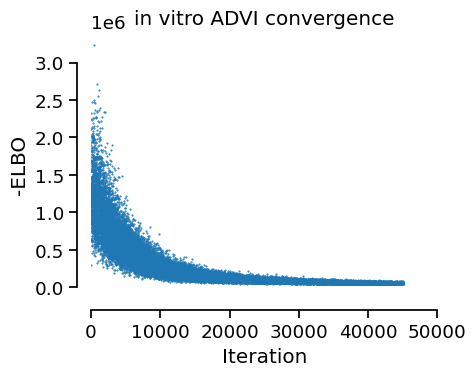

In [6]:
trace15 = run_BayesInf(BIOMD64_15)

In [11]:
Ex_15 = (trace15['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

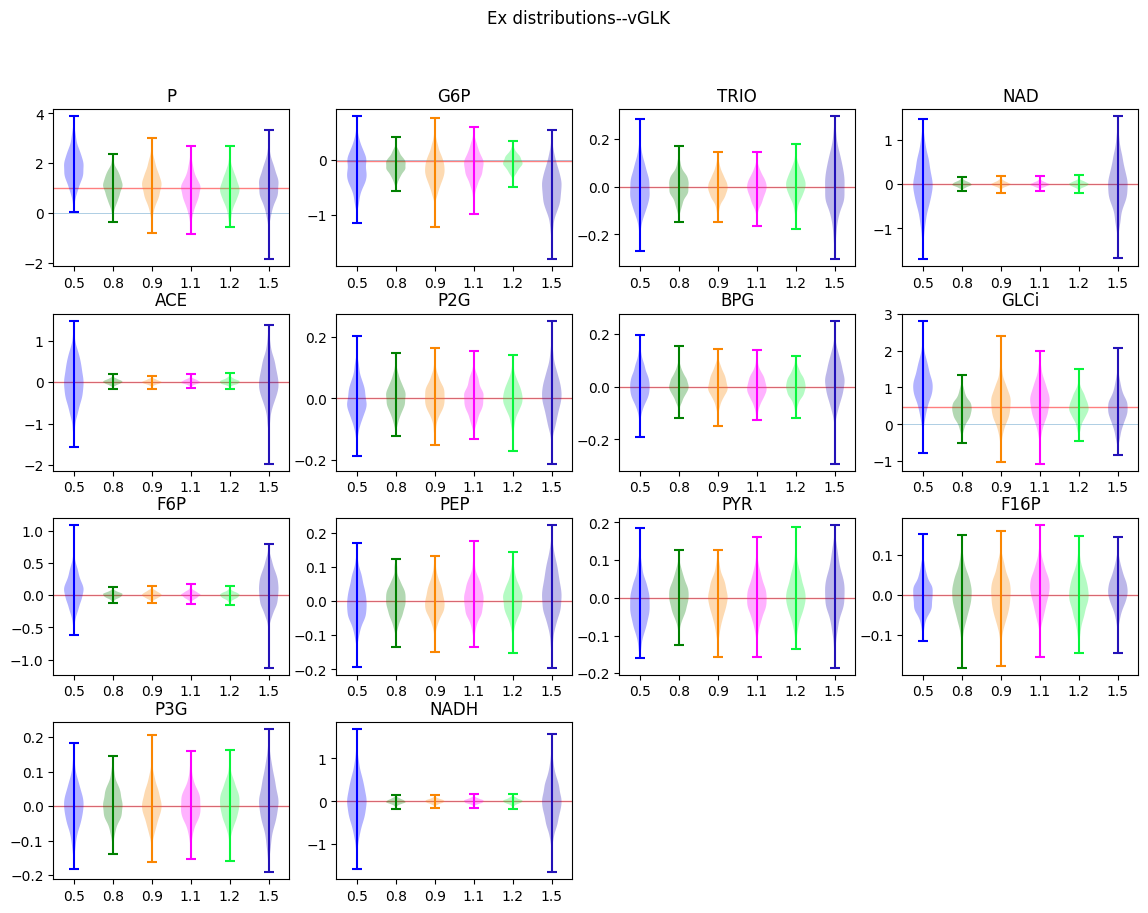

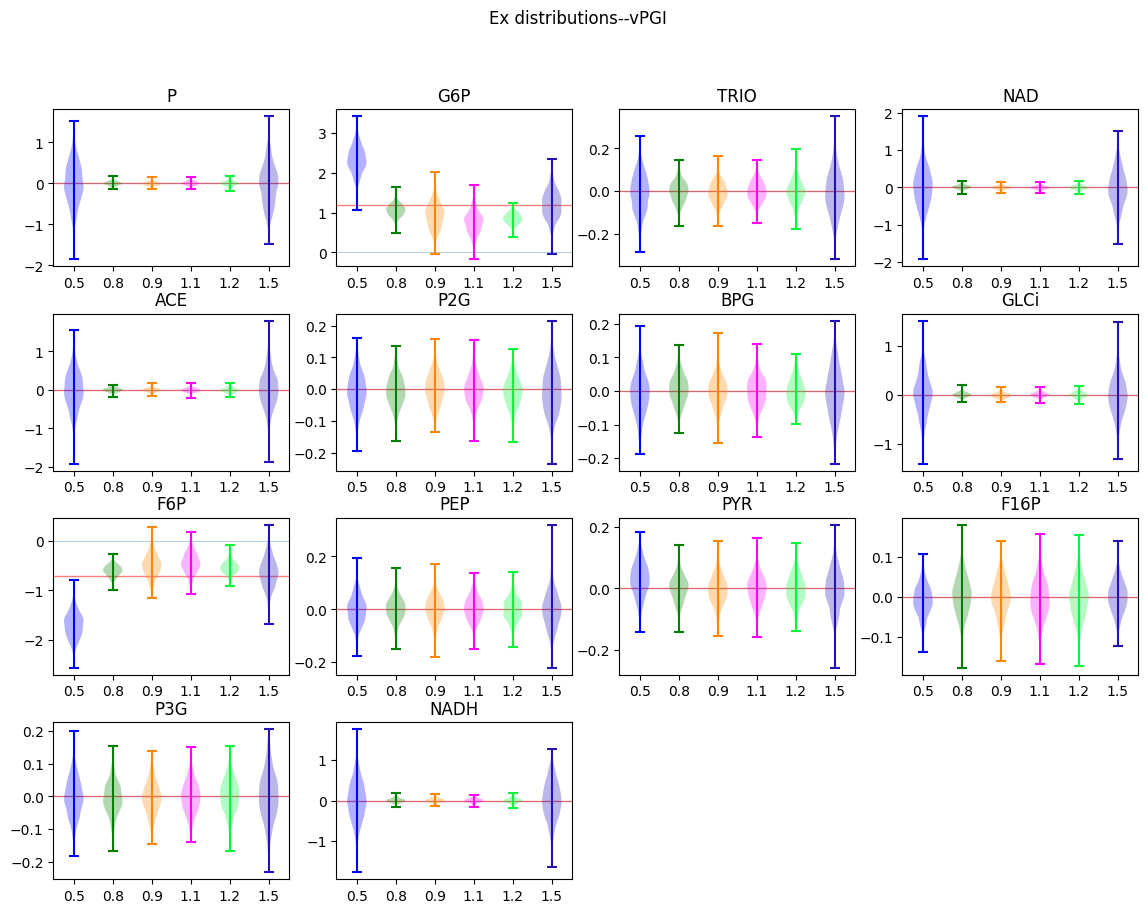

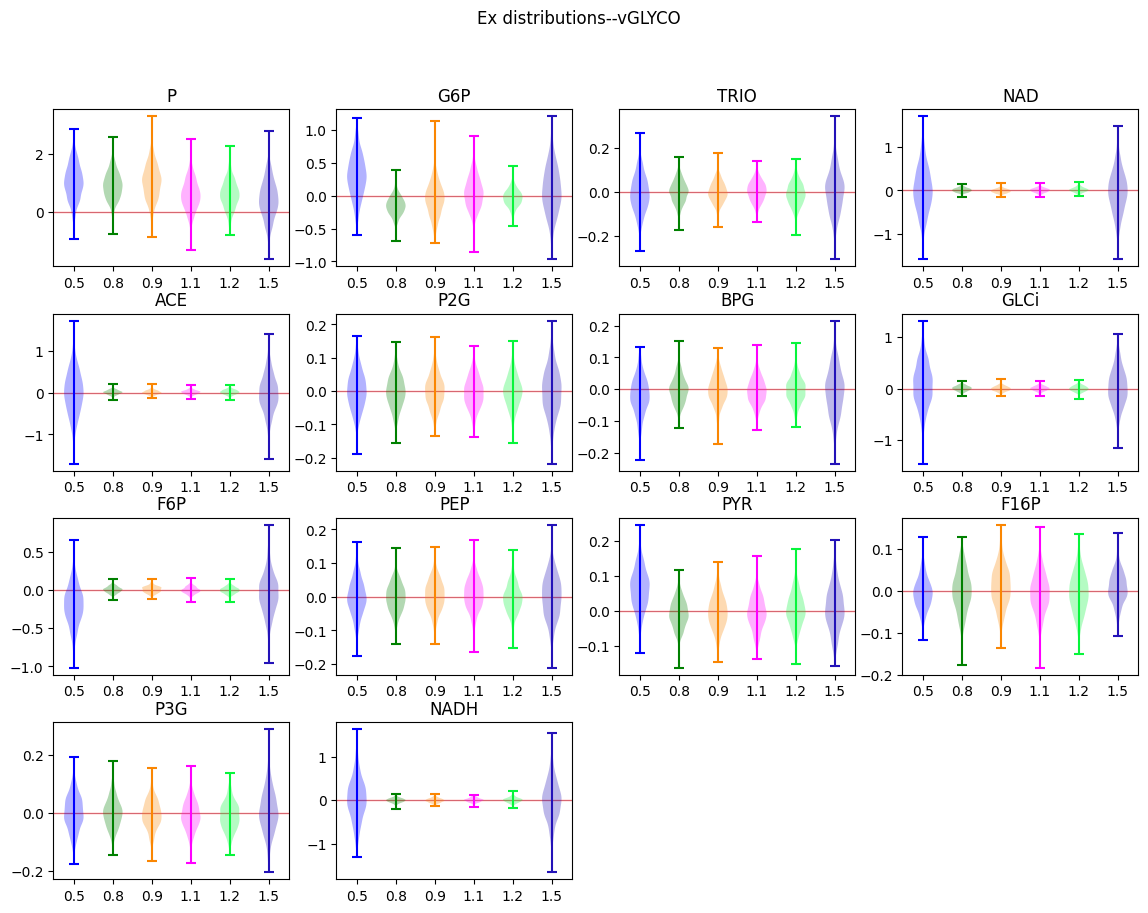

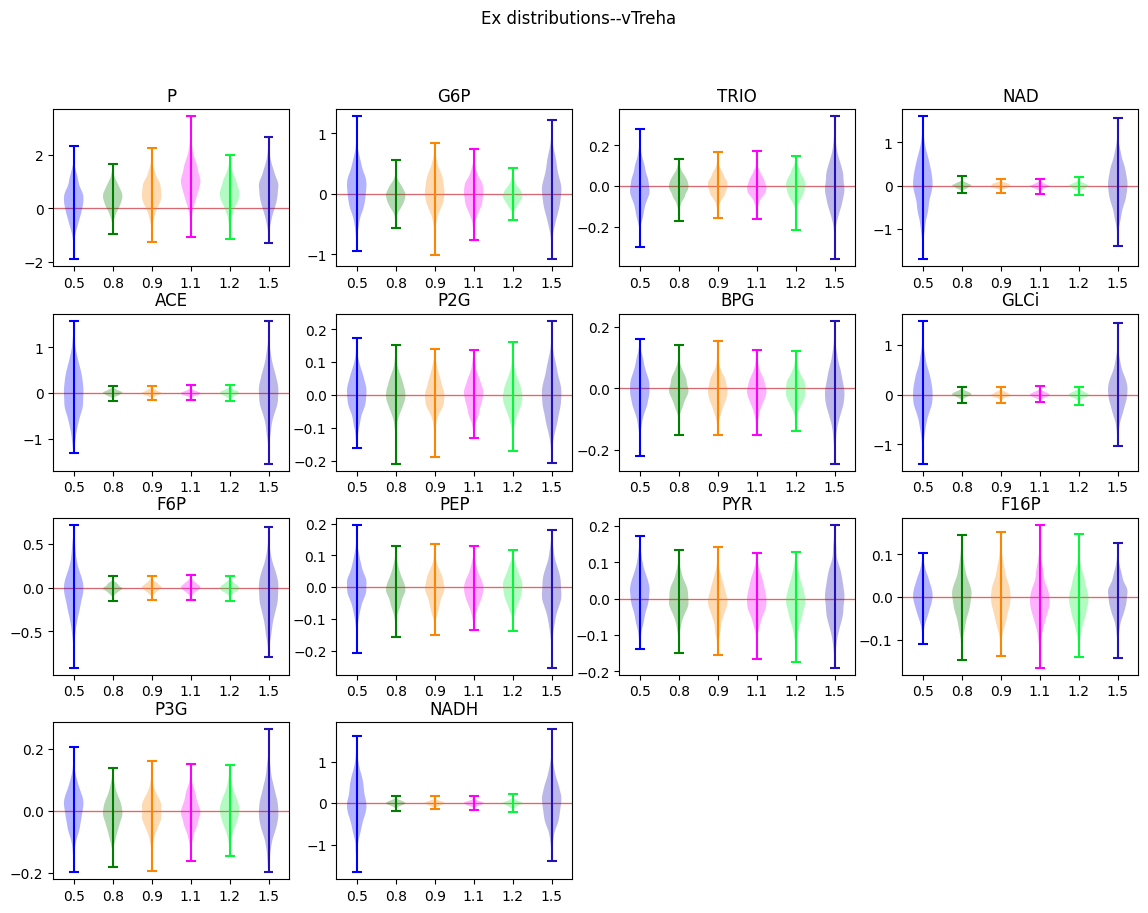

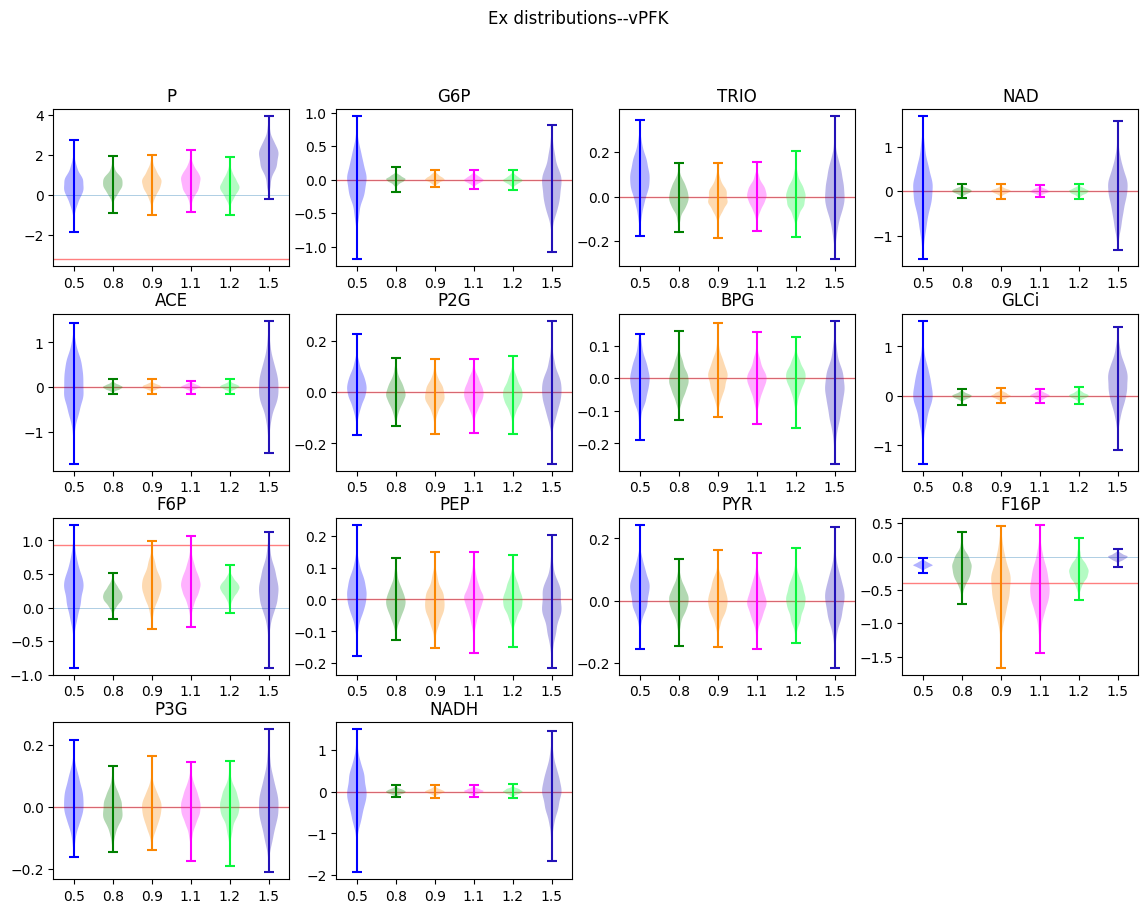

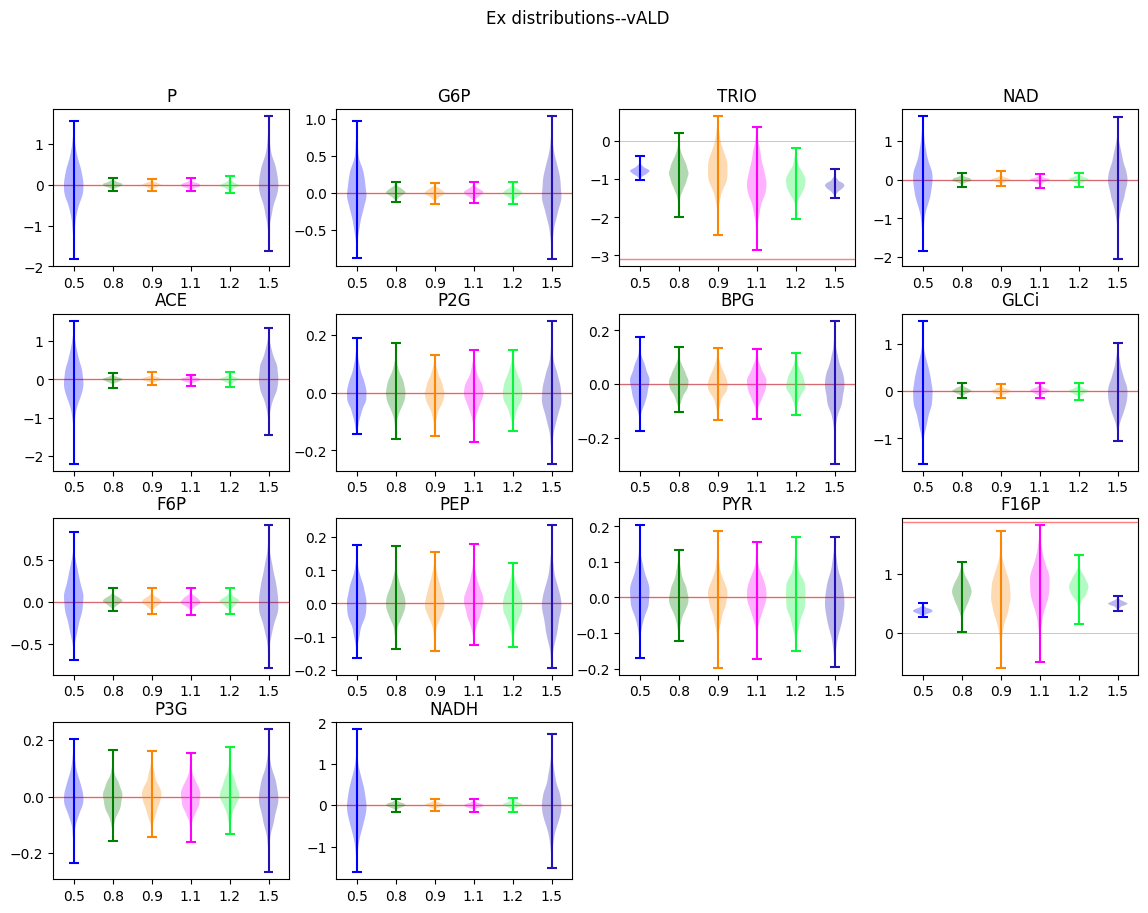

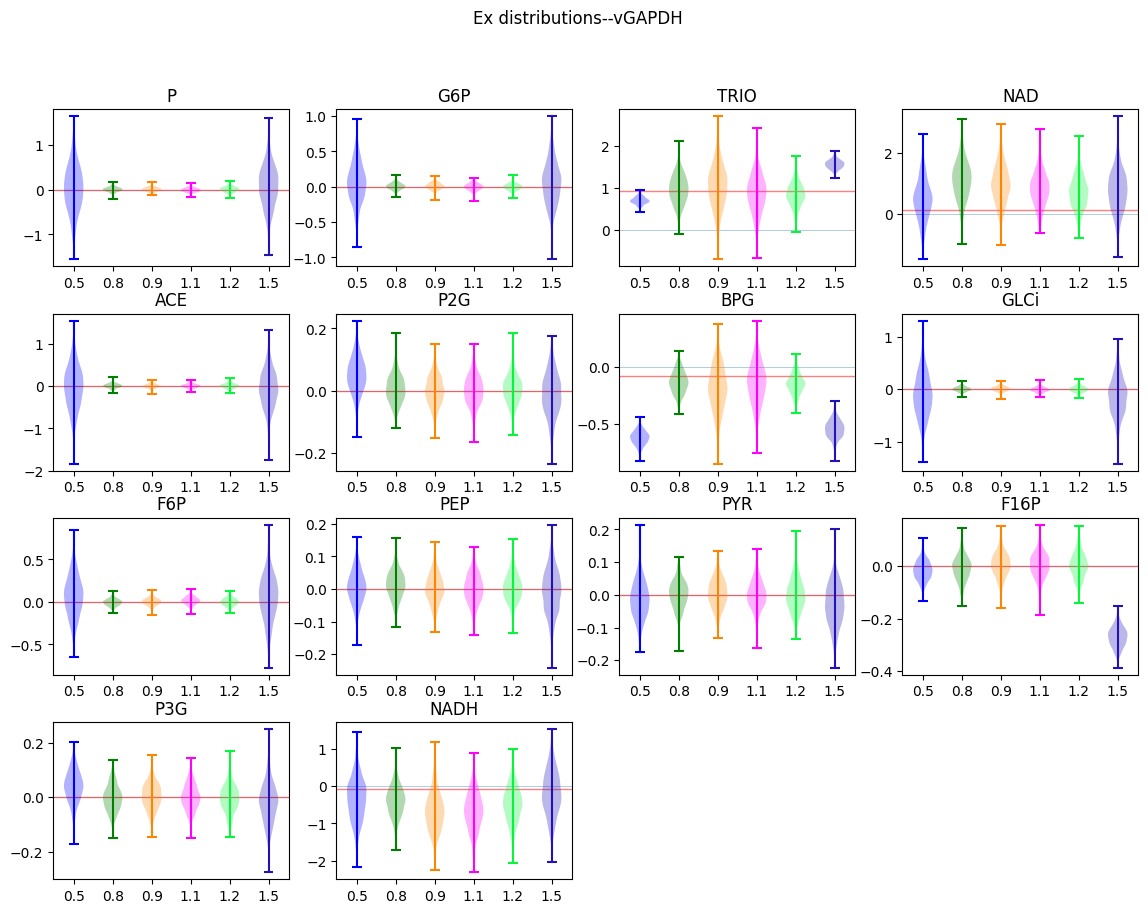

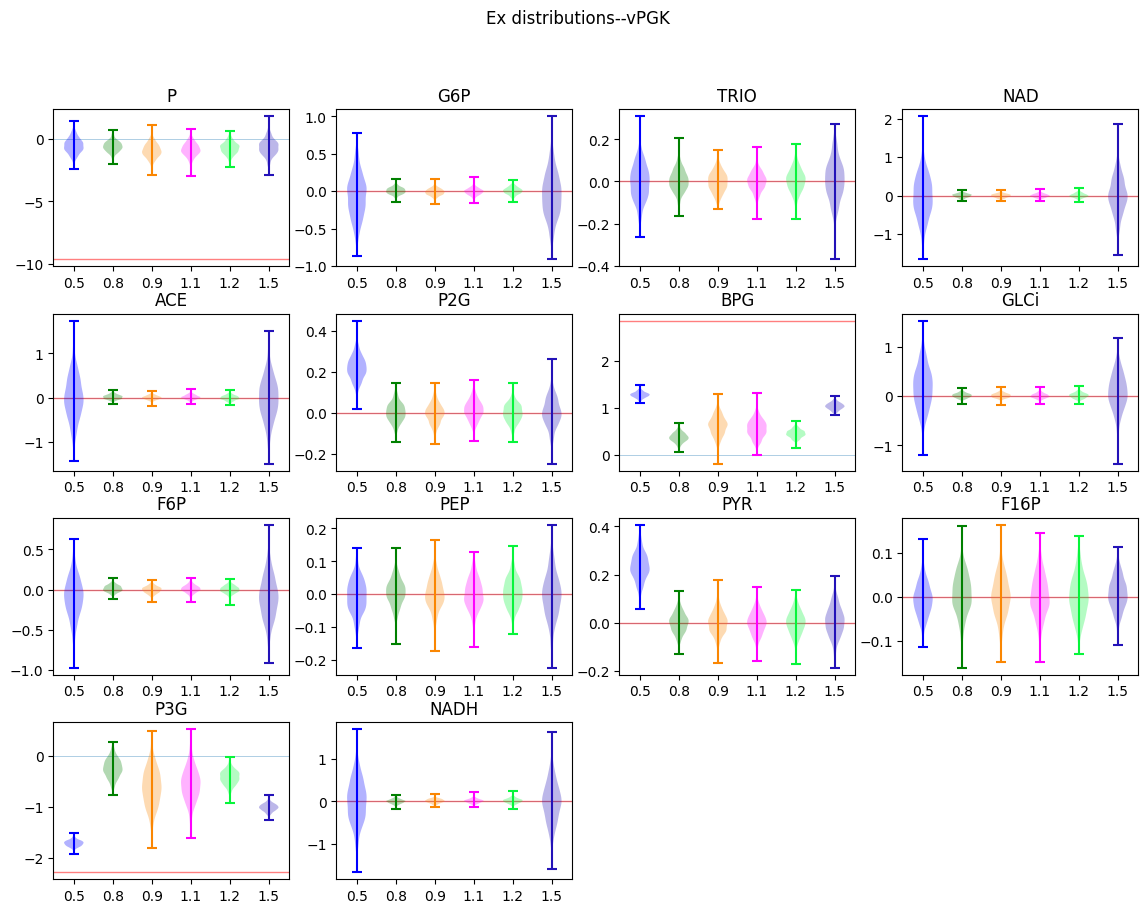

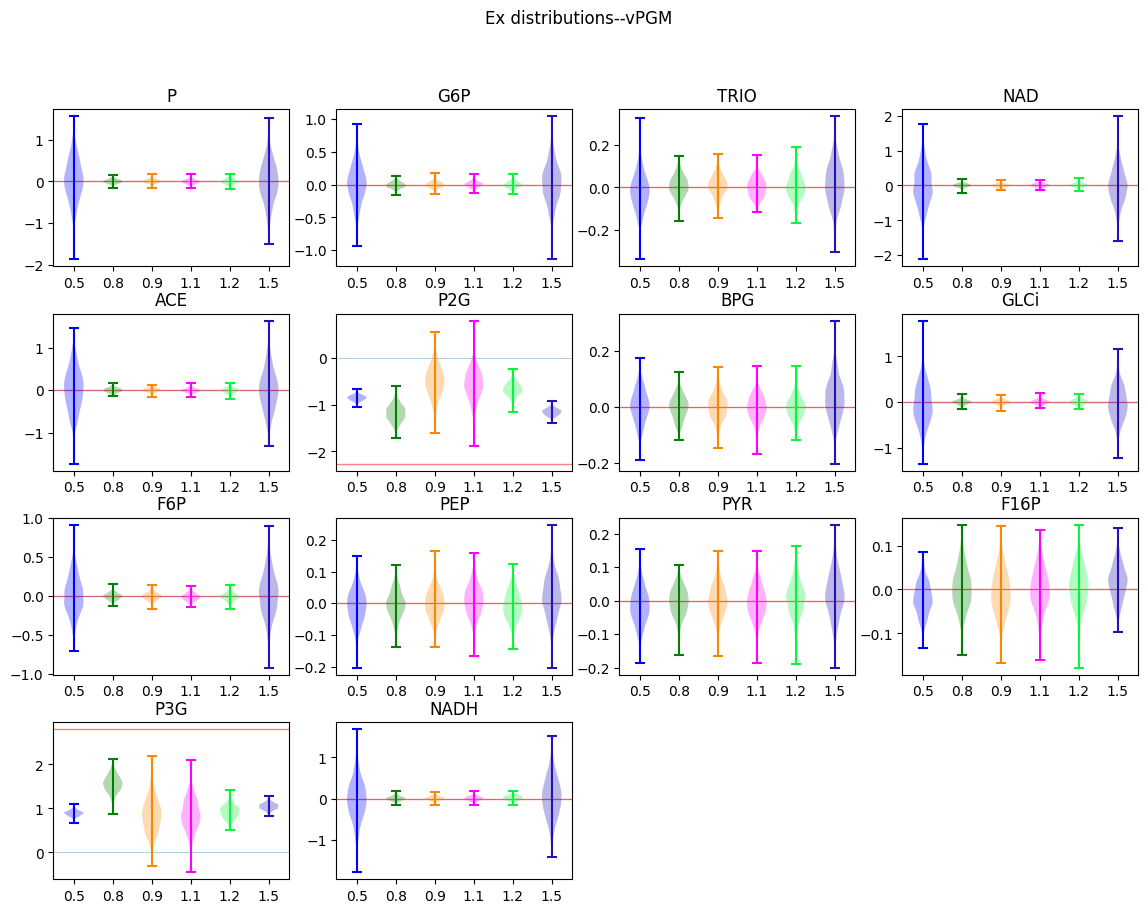

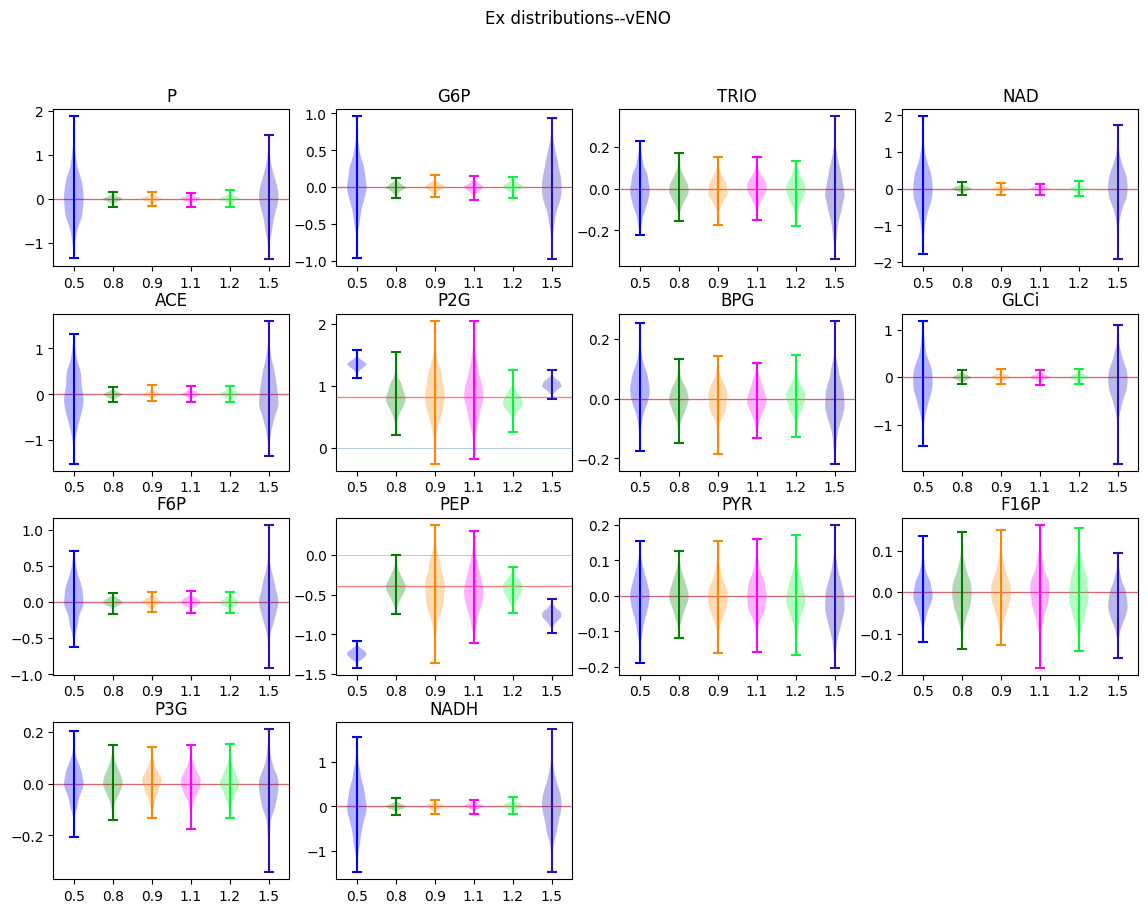

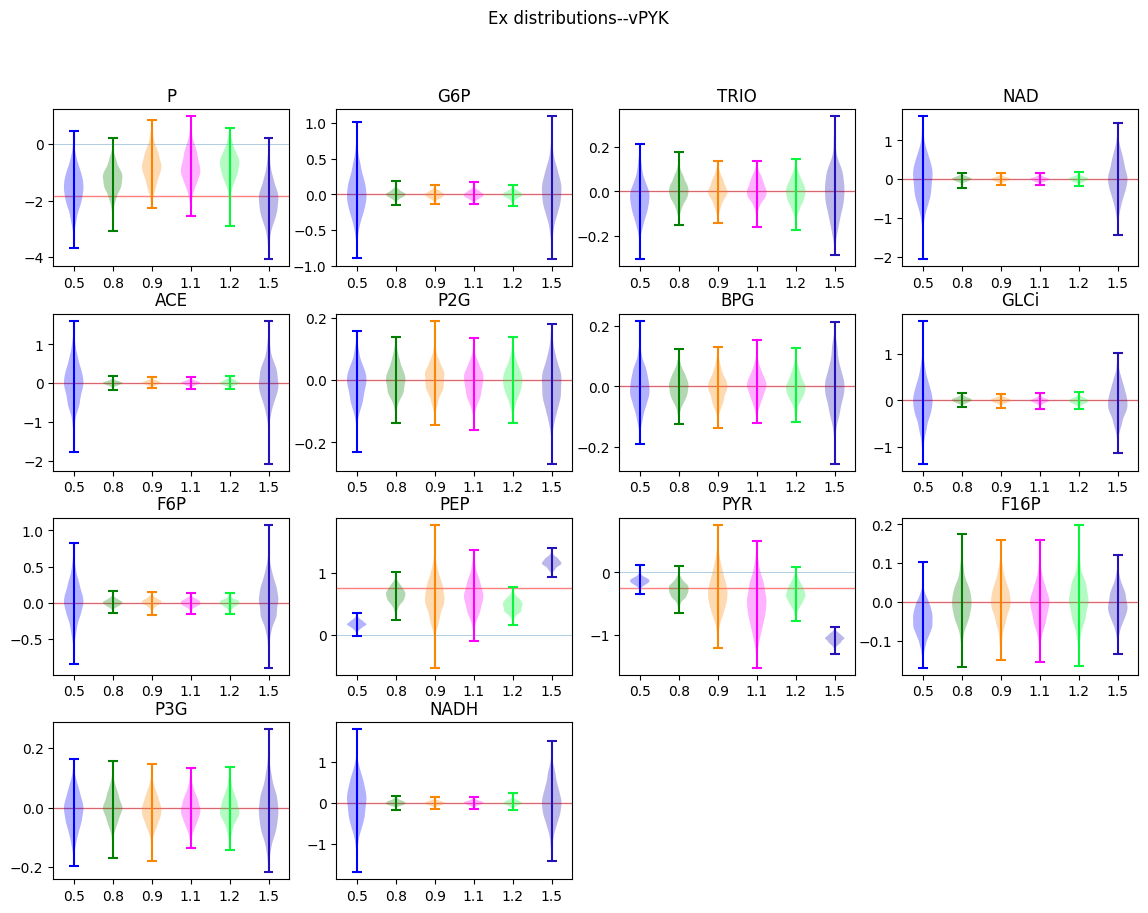

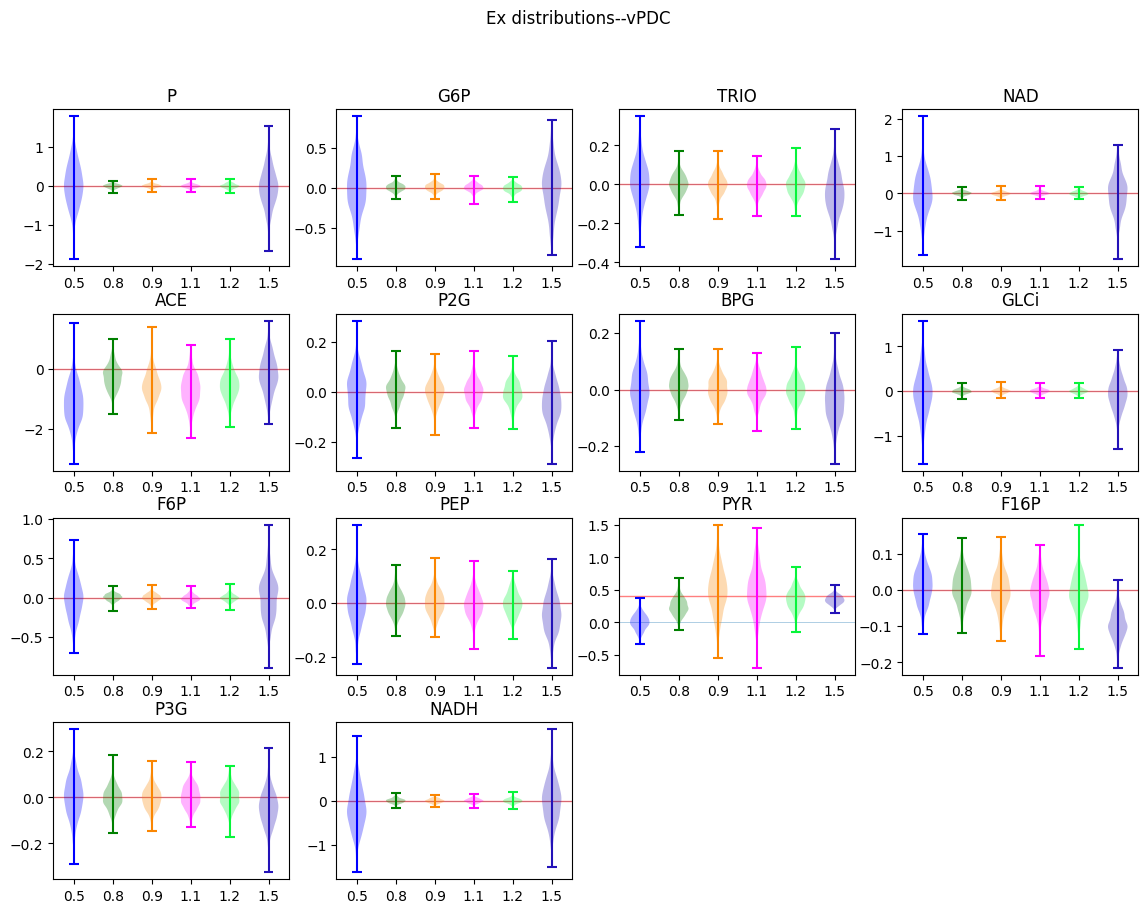

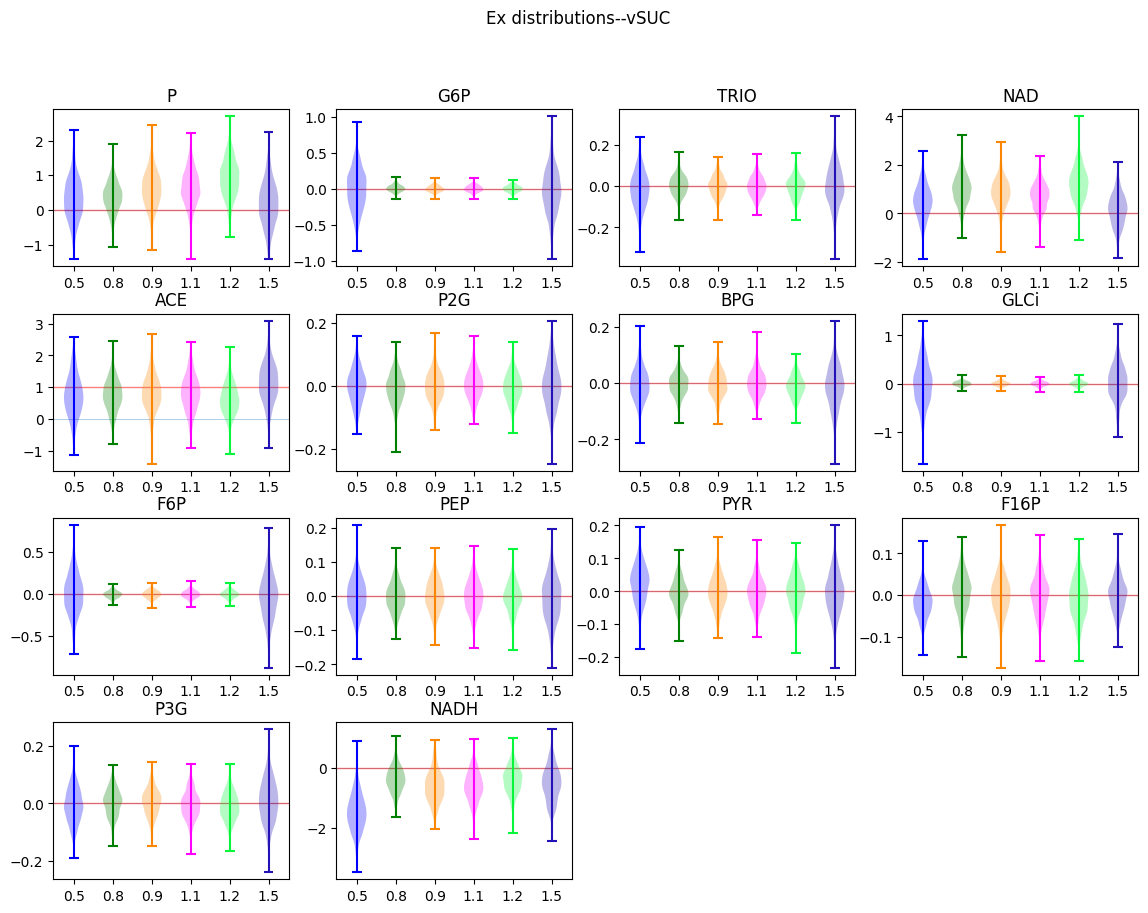

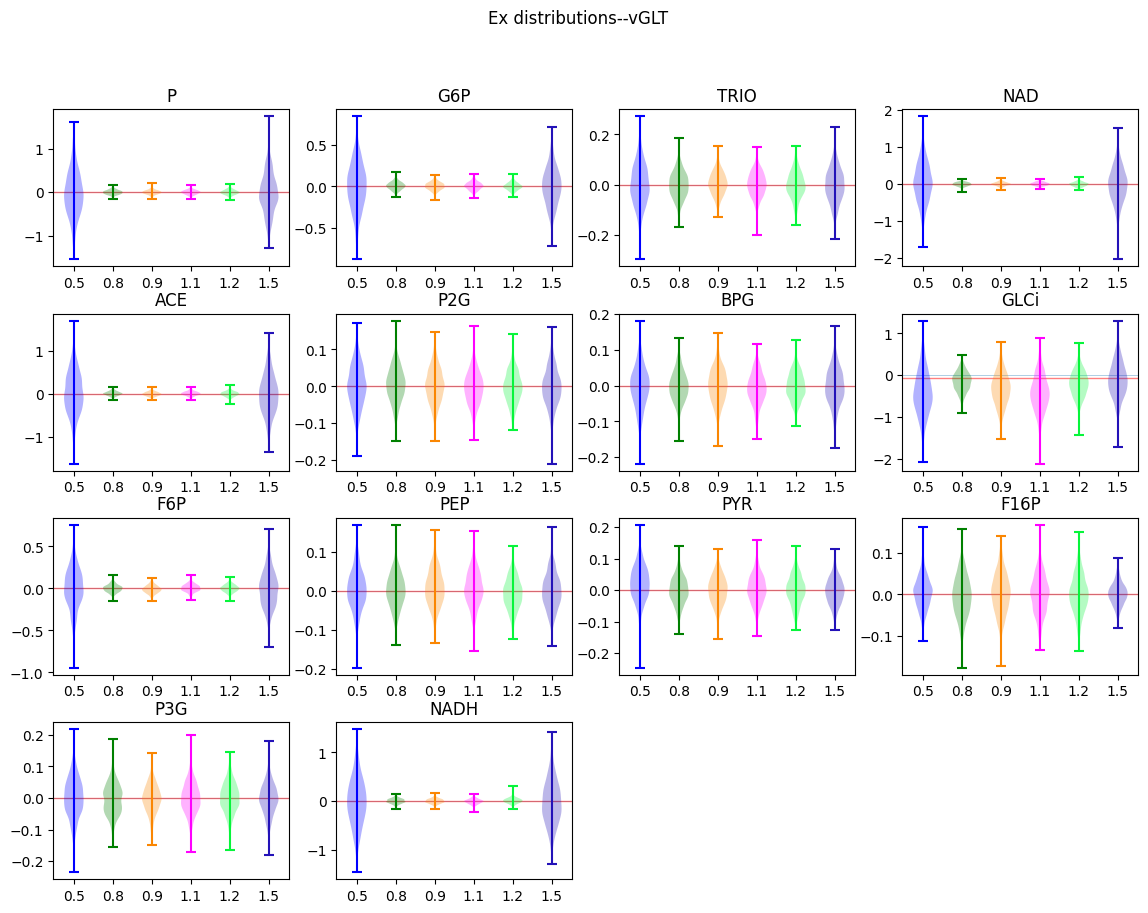

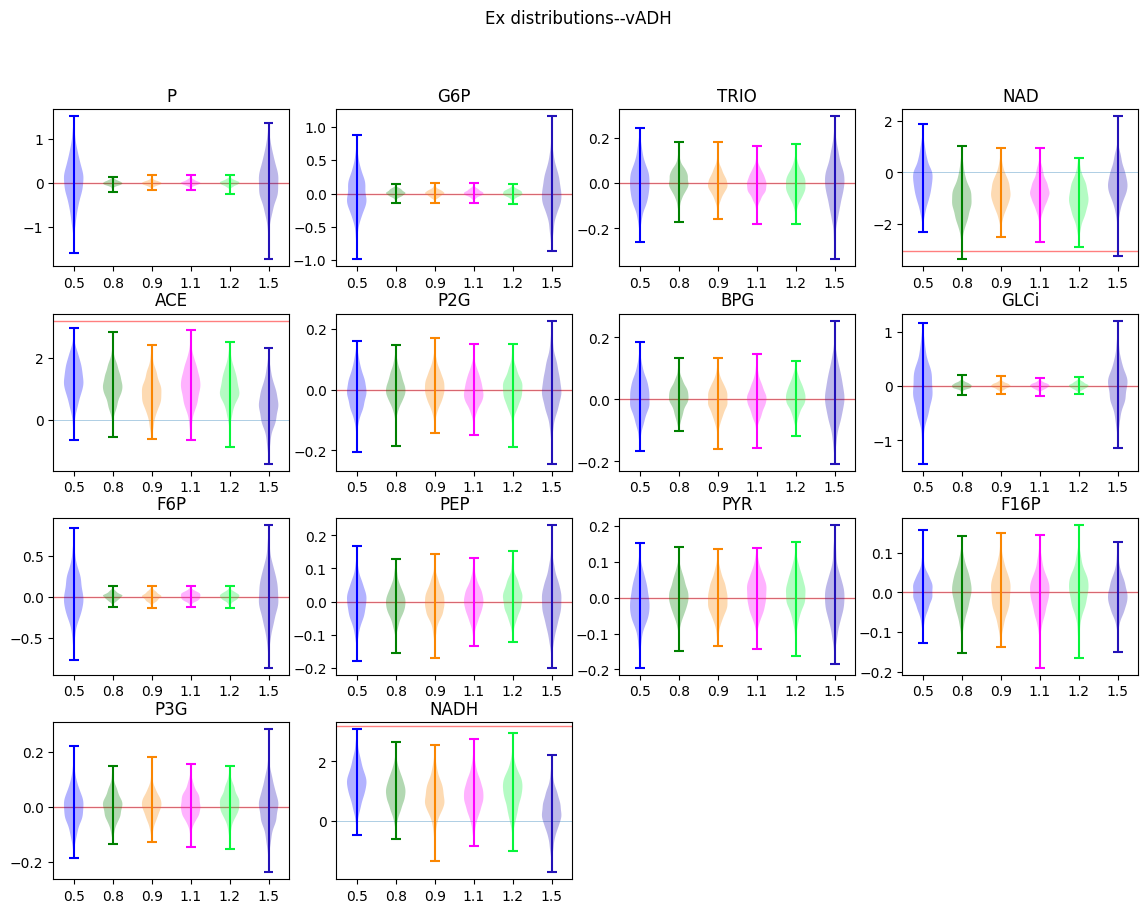

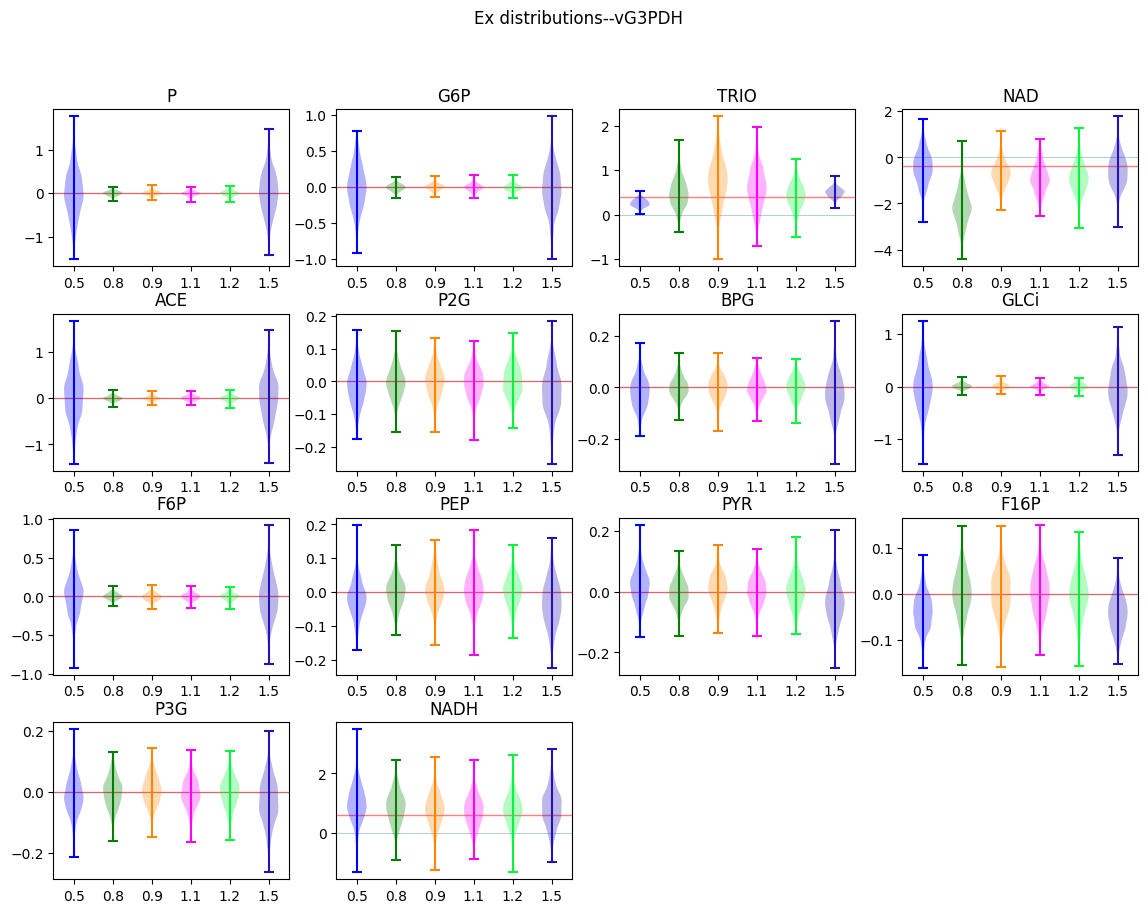

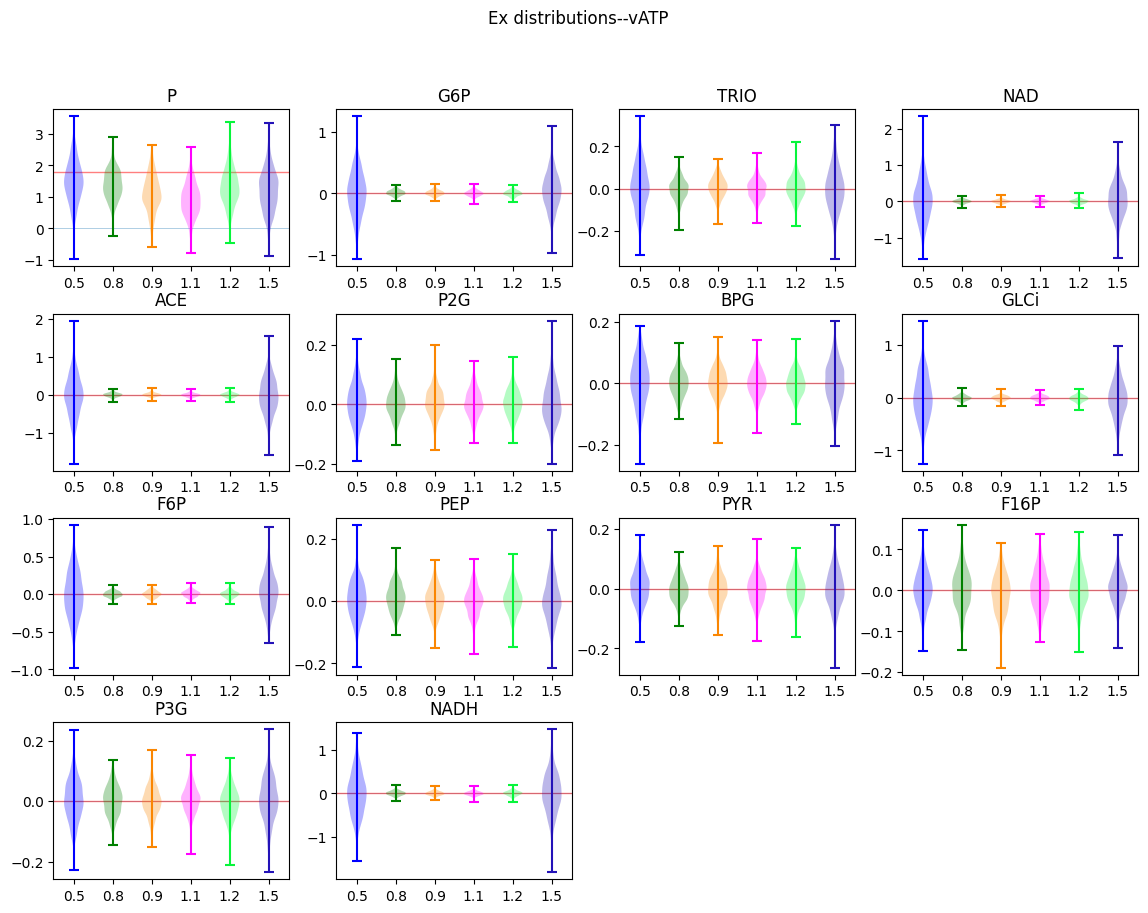

In [44]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(4,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    plt.setp(ax, xticks=range(7), xticklabels=['0', '0.5', '0.8', '0.9','1.1', '1.2', '1.5'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in (all_traces): 
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    fig.delaxes(ax[3,2]) 
    fig.delaxes(ax[3,3]) 